### Import Libraries and environment variables setup

In [67]:
import os
import load_dotenv
import nest_asyncio
nest_asyncio.apply()
load_dotenv.load_dotenv()
import asyncio
from playwright.async_api import async_playwright
from langchain_aws import ChatBedrock
from langchain_core.tools import Tool
from langchain_core.documents import Document
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import Send
from langchain_community.document_loaders import AsyncChromiumLoader, AsyncHtmlLoader, ScrapingAntLoader, SeleniumURLLoader, PlaywrightURLLoader
from langchain_community.document_transformers import BeautifulSoupTransformer, Html2TextTransformer
from langgraph.graph import StateGraph, START, END
from IPython.display import Markdown
from IPython.display import display, Image

### LLM Setup

In [68]:
llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_kwargs=dict(temperature=0.2),
)

In [69]:
llm.invoke("hi").content

'Hello! How can I help you today?'

### Structured output llms definition

In [71]:
from typing import Annotated, List, TypedDict, operator, Dict, Optional, Tuple
from pydantic import BaseModel, Field

# class Product(BaseModel):
#     name: str = Field(None, description="Product name."),
#     description: str = Field(None, description="Product description."),
#     model_number: str = Field(None, description="Product model number."),
#     price: float = Field(None, description="Product price."),
#     price_unit: str = Field(None, description="Product price unit."),
#     features: Dict = Field(None, description="Generic Product features."),
#     product_models: List[Dict] = Field(None, description="Product other vaiants details."),
#     images: List[str] = Field(None, description="Product images.")

class Product(BaseModel):
    product_id: str = Field(..., description="Unique product identifier.")
    name: str = Field(..., description="Standardized product name.")
    brand: str = Field(..., description="Brand information.")
    model_number: str = Field(..., description="Product model number.")
    description: str = Field(None, description="Product description.")
    specifications: Dict[str, str] = Field(..., description="Detailed product specifications.")
    product_models: List[Dict] = Field(None, description="Product vaiants detail."),
    images: List[str] = Field(..., description="List of high-quality product image URLs.")
    category: str = Field(..., description="Product category.")
    subcategory: Optional[str] = Field(None, description="Product subcategory.")
    price_range: Tuple[float, float] = Field(..., description="Pricing reference range (min, max).")
    price_unit: str = Field(..., description="Currency unit for pricing.")
    confidence_scores: Dict[str, float] = Field(..., description="Confidence score for each attribute indicating data quality.")
 
class ProductListing(BaseModel):
    products: List[Product] = Field(None, description="Product list with details for given category.")

class SearchQuery(BaseModel):
    search_query: str = Field(None, title="Search Query", description="Query that is optimized for search engines")
    justification: str = Field(None, title="Justification", description="Why this query is relevant for the user's request")
 
product_llm = llm.with_structured_output(Product)
search_query_llm = llm.with_structured_output(SearchQuery)

### Langgraph State Definition

In [72]:
# Graph State
class State(TypedDict):
    search_query: str
    product_listing_links: list
    category_name: str
    category_type: str
    products: List[Product]
    product_detail_page_links: Annotated[list, operator.add]
    completed_products: Annotated[list, operator.add] # all workers write to this in parallel

class ProductDetailPageLinkWorkerState(TypedDict):
    category_name: str
    product_listing_link: str
    product_detail_page_links: Annotated[list, operator.add]

class WorkerState(TypedDict):
    link: str
    products: List[Product]
    completed_products: Annotated[list, operator.add]

### Langgraph Function and Tools Define

In [73]:
search = GoogleSearchAPIWrapper()
def top_results(query):
    return search.results(query, 10, {
        "gl": "in",
        "hl": "en",
    })

tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=top_results,
)

In [74]:
async def scrape(link: str):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(link, wait_until="domcontentloaded", timeout=0)
        # await page.goto(link, wait_until="networkidle", timeout=0)

        html = await page.content()
        await browser.close()
        return html

### Langgraph Nodes Define

In [75]:
# Nodes
class CategoryType(BaseModel):
    category_type: str = Field(None, title="Category Type", description="Type of category one of [generic, brand]")

def check_brand_category_type(state: State):
    print("started.....")
    result = llm.with_structured_output(CategoryType).invoke(f"Check if {state['category_name']} is a brand product category or generic category.")
    print(result)
    return {"category_type": result.category_type}
    
def continue_or_stop(state: State):
    if state["category_type"] == "brand":
        return "get_search_engine_query"
    else:
        return END

def get_search_engine_query(state: State):
    search_query = llm.with_structured_output(SearchQuery).invoke(
        f"Get a simple user search query for {state['category_name']} category which is optimized for search engines."
        )
    print(search_query)
    return {"search_query": search_query.search_query}

class ProductListingPageLinks(BaseModel):
    links: list = Field(None, description="Product listing page links relevant to provided brand category name.")

def get_product_listing_page_links(state: State):
    product_listing_links = state.get('product_listing_links')
    if product_listing_links is None or len(product_listing_links) == 0:
        results = tool.run(state["search_query"])
        print(results)
        links = llm.with_structured_output(ProductListingPageLinks).invoke(
            f"Filter out product listing page links relevant to {state['category_name']} category in search results. results: {results}"
        )
        product_listing_links = links.links
        print("google search product listing links: ", product_listing_links)
    return {"product_listing_links": product_listing_links}

class PdpLinkPages(BaseModel):
    pdp_links: list = Field(None, description="Product detail page links relevant to provided product listing page links.")

def scrap_and_get_pdp_links(worker_state: ProductDetailPageLinkWorkerState):
    try:
        html = asyncio.run(scrape(worker_state["product_listing_link"]))
        html_transformer = Html2TextTransformer(ignore_links=False)
        docs_transformed = html_transformer.transform_documents([Document(page_content=html)])
        content = docs_transformed[0].page_content
        # print(content)
        
        product_detail_page_links = llm.with_structured_output(PdpLinkPages).invoke(
            [
                SystemMessage(content="You are proudct detail page url collector from given raw content."),
                HumanMessage(content=f"Give proper formatted list of product detail page links in following content belonging to {worker_state['category_name']} category if present else empty list: {content}")
            ]
        )
        domain_name = worker_state["product_listing_link"].split("/")[2]
        product_detail_page_links.pdp_links = [link if "http" in link else f"https://{domain_name}{link}" for link in product_detail_page_links.pdp_links]
        return {"product_detail_page_links": product_detail_page_links.pdp_links}
    except Exception as e:
        print(str(e))
        return {"error": str(e)}

def get_product_detail_page_links(state: State):
    print("Product Listing Links")
    print(state["product_listing_links"])
    return [Send("scrap_and_get_pdp_links", {"product_listing_link": link, "category_name": state["category_name"]}) for link in state["product_listing_links"]]

def scrap_and_get_products(worker_state: WorkerState):
    try:
        html = asyncio.run(scrape(worker_state["link"]))
        html_transformer = Html2TextTransformer(ignore_images=False)
        docs_transformed = html_transformer.transform_documents([Document(page_content=html)])
        content = docs_transformed[0].page_content
        
        product_result = product_llm.invoke(
            [
                SystemMessage(content="You are product detail extractor from given raw content."),
                HumanMessage(content=f"Give proper product detail in following content: {content}")
            ]
        )
        product_result.images = [image if "http" in image else f"https://{worker_state['link'].split('/')[2]}{image}" for image in product_result.images]
        return {"completed_products": [product_result]}
    except Exception as e:
        print(str(e))
        return {"error": str(e)}

def assign_workers_to_links(state: State):
    print("Product Detail Page Links")
    print(state["product_detail_page_links"])
    return [Send("scrap_and_get_products", {"link": link}) for link in state["product_detail_page_links"]]

def synthesizer(state: State):
    return {
        "products": state["completed_products"]
    }

### Compiling Langgraph

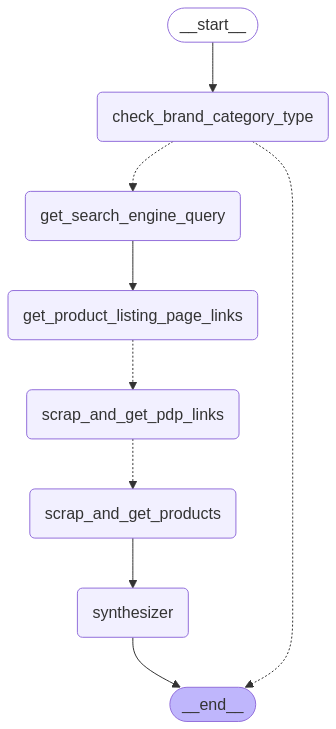

In [76]:
# Build workflow
b2b_products_repo_builder = StateGraph(State)

# Add the nodes
b2b_products_repo_builder.add_node("check_brand_category_type", check_brand_category_type)
b2b_products_repo_builder.add_node("get_search_engine_query", get_search_engine_query)
b2b_products_repo_builder.add_node("get_product_listing_page_links", get_product_listing_page_links)
b2b_products_repo_builder.add_node("scrap_and_get_pdp_links", scrap_and_get_pdp_links)
b2b_products_repo_builder.add_node("scrap_and_get_products", scrap_and_get_products)
b2b_products_repo_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
b2b_products_repo_builder.add_edge(START, "check_brand_category_type")
b2b_products_repo_builder.add_conditional_edges('check_brand_category_type', continue_or_stop, {
    "get_search_engine_query": 'get_search_engine_query',
    END: END
})
b2b_products_repo_builder.add_edge("get_search_engine_query", "get_product_listing_page_links")
b2b_products_repo_builder.add_conditional_edges(
    "get_product_listing_page_links", get_product_detail_page_links, ["scrap_and_get_pdp_links"]
)
b2b_products_repo_builder.add_conditional_edges(
    "scrap_and_get_pdp_links", assign_workers_to_links, ["scrap_and_get_products"]
)
b2b_products_repo_builder.add_edge("scrap_and_get_products", "synthesizer")
b2b_products_repo_builder.add_edge("synthesizer", END)

# Compile the workflow
b2b_products_repo = b2b_products_repo_builder.compile()

# Show the workflow
display(Image(b2b_products_repo.get_graph().draw_mermaid_png()))

In [77]:
state = b2b_products_repo.invoke({
    "category_name": "JCB Machine",
})

started.....
category_type='brand'
search_query='JCB construction equipment machinery' justification='This search query is optimized for finding JCB machines as it includes relevant keywords like "construction equipment" and "machinery" which are commonly associated with JCB products. The query is simple yet effective for search engines to understand the user\'s intent to find information about JCB construction machines.'
[{'title': 'Heavy Equipment | Construction Equipment & Machinery | JCB', 'link': 'https://www.jcb.com/en-us/construction', 'snippet': 'We are constantly evolving our range of over 300 machines. Visit our website frequently to learn more about new JCB products.'}, {'title': 'JCB (heavy equipment manufacturer) - Wikipedia', 'link': 'https://en.wikipedia.org/wiki/JCB_(heavy_equipment_manufacturer)', 'snippet': 'JCB (heavy equipment manufacturer) ... This article is about the equipment manufacturer. For the credit card company, see JCB (credit card company). "J. C.\xa0...

In [78]:
state['products']

[Product(product_id='JCB-AP-001', name='JCB Access Electric Scissors', brand='JCB', model_number='AP-ES-2023', description='JCB Access Electric Scissors range designed for rental companies and contractors worldwide. Features power to platform as standard. Certified to EN280 and complies with ANSI and CSA legislation.', specifications={'certification': 'EN280, ANSI, CSA compliant', 'type': 'Electric Scissors', 'power_supply': 'Electric', 'standard_feature': 'Power to platform'}, product_models=(FieldInfo(annotation=NoneType, required=False, default=None, description='Product vaiants detail.'),), images=['https://www.jcb.com/images/jcb-access-platforms.jpg'], category='Construction Equipment', subcategory='Access Platforms', price_range=(50000.0, 150000.0), price_unit='USD', confidence_scores={'name': 0.9, 'brand': 1.0, 'category': 0.9, 'specifications': 0.8, 'price_range': 0.6}),
 Product(product_id='JCB-BHL-2024', name='JCB Backhoe Loader', brand='JCB', model_number='BHL-2024', descrip

In [79]:
len(state['products'])

48

In [81]:
state['products'][1].dict()

/var/folders/6j/90fxt7w17_v5v0v_cdqhj18w0000gn/T/ipykernel_82714/4002298138.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  state['products'][1].dict()


{'product_id': 'JCB-BHL-2024',
 'name': 'JCB Backhoe Loader',
 'brand': 'JCB',
 'model_number': 'BHL-2024',
 'description': 'JCB Backhoe Loaders are versatile machines that combine excellent trenching, excavating, loading, lifting and material handling capabilities with the benefits of a single machine that is easy to maintain and simple to operate. Pioneered by JCB in 1953, they remain the world leader in Backhoe technology, innovation and capability.',
 'specifications': {'type': 'Backhoe Loader',
  'capabilities': 'Trenching, excavating, loading, lifting, material handling',
  'features': 'Easy maintenance, simple operation',
  'market_position': "World's most popular backhoe loader"},
 'product_models': (FieldInfo(annotation=NoneType, required=False, default=None, description='Product vaiants detail.'),),
 'images': ['https://www.jcb.com/images/jcb-backhoe-loader.jpg'],
 'category': 'Construction Equipment',
 'subcategory': 'Backhoe Loaders',
 'price_range': (75000.0, 150000.0),
 '

In [41]:
state = b2b_products_repo.invoke({
    "category_name": "Usha Sewing Machines",
    "product_listing_links": [
        "https://www.flipkart.com/sewing-machines/usha~brand/pr?sid=j9e,abm,0zg",
    ]
})

started.....
category_type='brand'
search_query='Usha sewing machines' justification='This is a straightforward search query targeting the Usha brand of sewing machines. It\'s simple, direct, and uses the exact brand name "Usha" along with the product category "sewing machines" which will help users find relevant results in search engines.'
Product Listing Links
['https://www.flipkart.com/sewing-machines/usha~brand/pr?sid=j9e,abm,0zg']
Product Detail Page Links
['https://www.flipkart.com/usha-craft-master-industria-manual-sewing-machine/p/itm03224df3ca385', 'https://www.flipkart.com/usha-anand-composite-h-manual-sewing-machine/p/itm3c3e1ade332e0', 'https://www.flipkart.com/usha-craft-master-delux-industrial-manual-sewing-machine/p/itmf22ad54c21b19', 'https://www.flipkart.com/usha-bandhan-composite-c-manual-sewing-machine/p/itmf7u4qfh7ftzew', 'https://www.flipkart.com/usha-aayush-manual-sewing-machine/p/itm8504b941c61ea', 'https://www.flipkart.com/usha-bandhan-dlx-composite-cover-manual

In [42]:
state['products']

[Product(product_id='USHA-CRAFT-MASTER-IND', name='USHA CRAFT MASTER Industria Manual Sewing Machine', brand='USHA', model_number='CRAFT MASTER Industria', description='Manual sewing machine with 1 built-in stitch pattern and sewing speed of 1800 SPM. Suitable for domestic use.', specifications={'Type': 'Manual', 'Number of Stitches': '1', 'Sewing Speed': '1800 SPM', 'Color': 'Black', 'Width': '23 cm', 'Height': '33 cm', 'Depth': '33 cm', 'Weight': '15.2 kg', 'Number of Buttonhole Styles': '0'}, images=['https://rukminim2.flixcart.com/image/416/416/xif0q/sewing-machine/f/t/h/craft-master-industria-0-1-usha-original-imah7df3xtp7thtq.jpeg', 'https://rukminim2.flixcart.com/image/128/128/xif0q/sewing-machine/7/j/e/craft-master-industria-0-1-usha-original-imah7df3hxsxn5kz.jpeg', 'https://rukminim2.flixcart.com/image/128/128/xif0q/sewing-machine/f/n/2/craft-master-industria-0-1-usha-original-imah7df3nkwy89vt.jpeg', 'https://rukminim2.flixcart.com/image/128/128/xif0q/sewing-machine/i/3/p/craf